# Applying Data Science Model Development (MLP)

## 1. Preprocess the data

In [4]:
# === Step 0: Import Libraries ===
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# === Step 1: Data Preparation ===
df = pd.read_csv("Final_v2_processed.csv")
test_df = pd.read_csv("Final_test_v2_processed.csv")

#Use LabelEncoder to convert the category variable addr_state to a numeric encoding.
le = LabelEncoder()
df["addr_state"] = le.fit_transform(df["addr_state"])
test_df["addr_state"] = le.transform(test_df["addr_state"])

#Specify the target and feature columns
target_col = "loan_status"
feature_cols = [col for col in df.columns if col != target_col and col != "id"]

# Extracting features and labels (to numpy arrays)
X = df[feature_cols].values
y = df[target_col].values
X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

# Standardised feature data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# Delineate the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build PyTorch custom dataset classes
class LoanDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Construct training, validation and test sets
train_dataset = LoanDataset(X_train, y_train)
val_dataset = LoanDataset(X_val, y_val)
test_dataset = LoanDataset(X_test, y_test)

## 2. Define MLP Model

In [6]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),  # Input to first hidden layer
            nn.ReLU(),
            nn.Linear(64, 32),          # Second hidden layer
            nn.ReLU(),
            nn.Linear(32, 2)            # Output layer (binary classification)
        )

    def forward(self, x):
        return self.model(x)


## 3. Optuna Hyperparameter Tuning

In [7]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = MLPClassifier(input_size=X.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(10):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.numpy())
            y_true.extend(y_batch.numpy())

    return 1 - f1_score(y_true, y_pred, average="weighted")  # Optuna minimizes this value

# Run Optuna study
study = optuna.create_study()
study.optimize(objective, n_trials=20)
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)



[I 2025-04-10 03:34:03,061] A new study created in memory with name: no-name-bebb8ddf-a6b7-482b-b6b5-76d9728eab63
[I 2025-04-10 03:34:49,180] Trial 0 finished with value: 0.028730638253177454 and parameters: {'lr': 0.0007240994952404828, 'batch_size': 128}. Best is trial 0 with value: 0.028730638253177454.
[I 2025-04-10 03:36:40,788] Trial 1 finished with value: 0.028367372328682028 and parameters: {'lr': 0.002236024326313391, 'batch_size': 32}. Best is trial 1 with value: 0.028367372328682028.
[I 2025-04-10 03:37:49,889] Trial 2 finished with value: 0.028806128510499573 and parameters: {'lr': 0.002766906892265163, 'batch_size': 64}. Best is trial 1 with value: 0.028367372328682028.
[I 2025-04-10 03:38:39,654] Trial 3 finished with value: 0.02967031698465683 and parameters: {'lr': 0.008448132313962705, 'batch_size': 128}. Best is trial 1 with value: 0.028367372328682028.
[I 2025-04-10 03:39:47,527] Trial 4 finished with value: 0.03034964215206082 and parameters: {'lr': 0.00010431428254

Best hyperparameters: {'lr': 0.002659449520726909, 'batch_size': 32}


## 4. Re-learn with the optimized parameters

Epoch 1 - Train Loss: 0.0928, Val Loss: 0.0851
Epoch 2 - Train Loss: 0.0802, Val Loss: 0.0818
Epoch 3 - Train Loss: 0.0776, Val Loss: 0.0818
Epoch 4 - Train Loss: 0.0763, Val Loss: 0.0793
Epoch 5 - Train Loss: 0.0756, Val Loss: 0.0807
Epoch 6 - Train Loss: 0.0744, Val Loss: 0.0795
Epoch 7 - Train Loss: 0.0731, Val Loss: 0.0793
Epoch 8 - Train Loss: 0.0728, Val Loss: 0.0789
Epoch 9 - Train Loss: 0.0717, Val Loss: 0.0815
Epoch 10 - Train Loss: 0.0712, Val Loss: 0.0785
Epoch 11 - Train Loss: 0.0700, Val Loss: 0.1453
Epoch 12 - Train Loss: 0.0699, Val Loss: 0.0809
Epoch 13 - Train Loss: 0.0691, Val Loss: 0.0808
Epoch 14 - Train Loss: 0.0686, Val Loss: 0.0834
Epoch 15 - Train Loss: 0.0680, Val Loss: 0.0789
Early stopping triggered at epoch 15


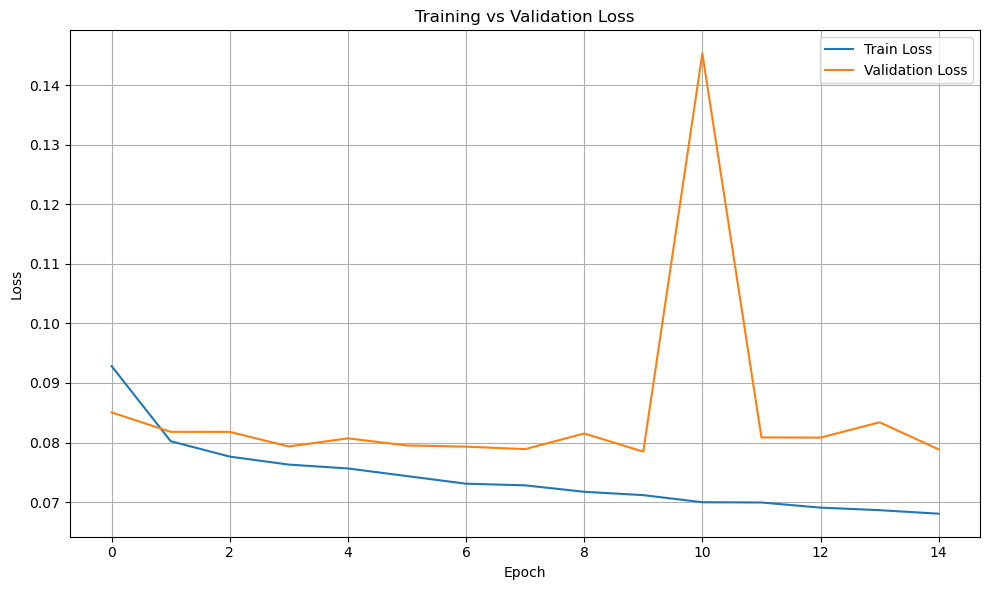

In [8]:
# === Step 4: Train Final Model with Best Parameters ===
batch_size = best_params['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = MLPClassifier(input_size=X.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

# Training loop with early stopping
for epoch in range(20):
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

# Validation phase
    model.eval()
    running_val_loss = 0.0
    predicted_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            predicted_labels.extend(preds.numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Plot learning curve (Train vs Validation Loss) 
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Evaluate the model


Evaluation Metrics on Training Set:
F1 Score (weighted): 0.9752
Precision: 0.9835
Recall: 0.8690
AUC-ROC: 0.9930
Confusion Matrix:
[[115957    337]
 [  3029  20100]]


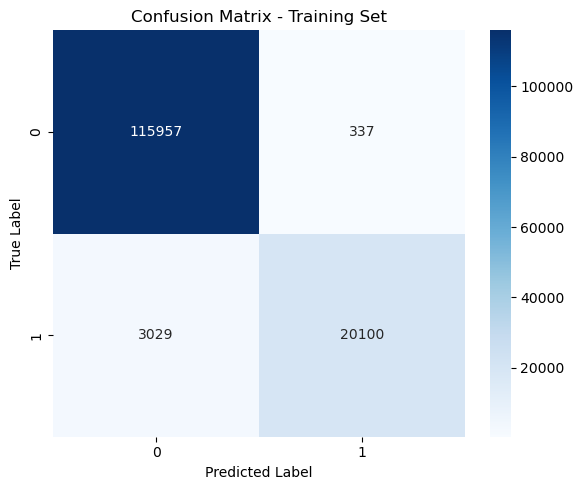


Evaluation Metrics on Validation Set:
F1 Score (weighted): 0.9713
Precision: 0.9764
Recall: 0.8520
AUC-ROC: 0.9892
Confusion Matrix:
[[28959   119]
 [  855  4923]]


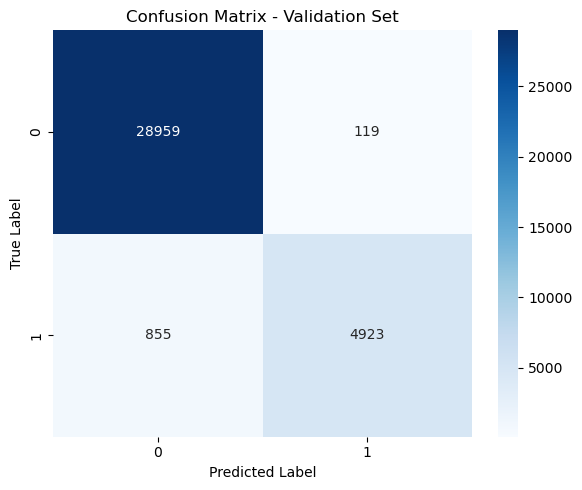


Evaluation Metrics on Test Set:
F1 Score (weighted): 0.9571
Precision: 0.9781
Recall: 0.6025
AUC-ROC: 0.9533
Confusion Matrix:
[[117097    164]
 [  4840   7337]]


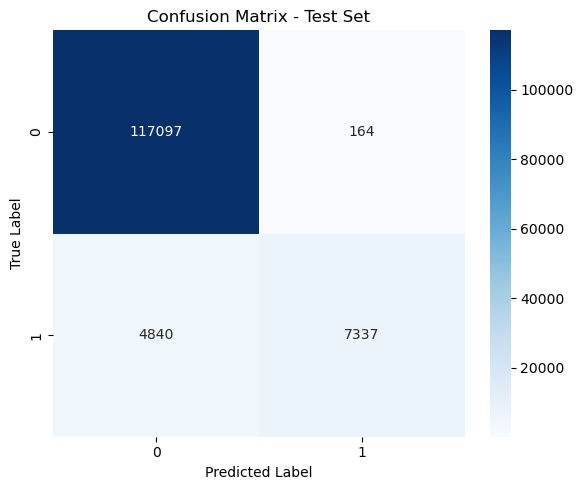

In [9]:
# === Step 5: Evaluate on All Datasets ===

def evaluate_model(dataloader, dataset_name=""):
    model.eval()
    y_pred, y_true, y_prob = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            y_true.extend(y_batch.numpy())
            y_pred.extend(preds.numpy())
            y_prob.extend(probs[:, 1].numpy())

    # Calculate evaluation metrics
    f1 = f1_score(y_true, y_pred, average="weighted")
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)

    # Print metrics
    print(f"\nEvaluation Metrics on {dataset_name}:")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.tight_layout()
    plt.show()


# Load best model weights
model.load_state_dict(best_model_state)

# Create all data loaders
train_loader_eval = DataLoader(train_dataset, batch_size=64)
val_loader_eval = DataLoader(val_dataset, batch_size=64)
test_loader_eval = DataLoader(test_dataset, batch_size=64)

# Evaluate on all datasets
evaluate_model(train_loader_eval, "Training Set")
evaluate_model(val_loader_eval, "Validation Set")
evaluate_model(test_loader_eval, "Test Set")
